

---
Gerekli Kütüphaneler yükleniyor


In [ ]:
!pip install xgboost

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
from collections import Counter



---
Drive içerisine alınan HIGGS veri setinin 100 bin lik örneği okunuyor.


In [ ]:
# Veri Yükleme
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Makine Öğrenmesi/HIGGS_100bin.csv", header=None)
df_sample = df.sample(n=20000, random_state=42)
df_sample.head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
75721,1,0.651878,-0.120826,-0.056837,0.965976,1.346739,0.727361,0.947625,-1.435222,2.173076,...,1.037237,-0.042993,0.000000,1.592380,1.424550,1.048466,0.927705,0.916218,1.054933,0.890205
80184,0,1.197245,0.311616,-0.296537,1.217326,0.357775,1.015191,0.866426,-1.399188,0.000000,...,-0.627577,-0.046877,0.000000,1.268488,0.906525,0.984162,0.682697,0.569413,0.709651,0.790514
19864,0,0.821711,-1.569118,-0.127859,0.430256,-1.290254,1.115135,-1.439820,0.324470,2.173076,...,0.824867,1.495881,3.101961,0.942954,0.529800,0.987567,0.865922,1.339817,1.659714,1.352600
76699,1,1.064198,-0.641900,1.168954,0.543271,0.609208,1.109363,-0.162423,1.332325,2.173076,...,-0.235317,-1.504079,3.101961,0.845645,1.529571,0.980615,0.691882,0.880277,1.298323,1.084701
92991,1,0.313312,-1.536977,1.093493,0.875201,0.384594,1.106615,0.327741,-1.573262,2.173076,...,-0.194509,0.593040,0.000000,0.745128,1.072869,0.995559,0.714520,1.512877,0.911191,0.766738




---
ilk kolon ayrı tutularak aykırı değer temizliği yapılıyor.


In [ ]:
y = df_sample.iloc[:, 0]
X = df_sample.drop(columns=df_sample.columns[0])

# Aykırı Değer Temizliği (IQR)
mask = pd.Series([True] * X.shape[0], index=X.index)
for col in X.columns:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    mask &= (X[col] >= lower) & (X[col] <= upper)

X_clean = X[mask]
y_clean = y[mask]



---
Standart Scaler ile sayısal veriler ölçekleniyor.


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_clean.columns, index=X_clean.index)



---
Dışta 5 fold içeride 3 fold olacak şekilde cross validation yapısı kuruluyor.



*   FLOWCHART - A
*   En iyi özellik seçimi döngü içerisinde k_values ile kullanılıyor. (5,10,15,20)
*   Hiperparametreler sabit




In [ ]:
# %80 - %20 eğitim-test ayrımı
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y_clean, test_size=0.2, stratify=y_clean, random_state=42)

# Nested CV Ayarları
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

models_fixed = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(C=1.0, kernel="linear", probability=True),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), activation="relu", max_iter=500),
    "XGBoost": XGBClassifier(learning_rate=0.1, max_depth=3, use_label_encoder=False, eval_metric='logloss')
}

fixed_results = []
feature_counts_fixed = Counter()

for outer_fold, (train_idx, val_idx) in enumerate(outer_cv.split(X_train, y_train), 1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    for model_name, model in models_fixed.items():
        best_acc = 0
        best_k = 5
        best_pipeline = None
        best_features = []

        for k in range(5, min(21, X_tr.shape[1])):
            pipeline = Pipeline([
                ('select', SelectKBest(score_func=f_classif, k=k)),
                ('clf', model)
            ])
            score = cross_val_score(pipeline, X_tr, y_tr, cv=inner_cv, scoring="accuracy").mean()
            if score > best_acc:
                best_acc = score
                best_k = k
                best_pipeline = pipeline

        # Eğitimi ve değerlendirmeyi yap
        best_pipeline.fit(X_tr, y_tr)
        y_pred = best_pipeline.predict(X_val)
        y_proba = best_pipeline.predict_proba(X_val)[:, 1]

        acc = accuracy_score(y_val, y_pred)
        auc_score = roc_auc_score(y_val, y_proba)

        selector = best_pipeline.named_steps['select']
        selected_features = X_tr.columns[selector.get_support()]
        feature_counts_fixed.update(selected_features)

        fixed_results.append({
            'fold': outer_fold,
            'model': model_name,
            'params': model.get_params(),
            'k_best': best_k,
            'outer_acc': acc,
            'outer_auc': auc_score,
            'selected_features': list(selected_features)
        })

# DataFrame'e çevir
results_df_fixed = pd.DataFrame(fixed_results)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro



---
Oluşan sonuçlara göre;

*   ROC Eğrileri
*   Detaylı Sonuçlar
*   Özellik Seçim Sonuçları Analizi
*   Özellik Seçim Grafikleri
*   Sonuç Test Analizleri
yazdırılıyor








/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:37:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


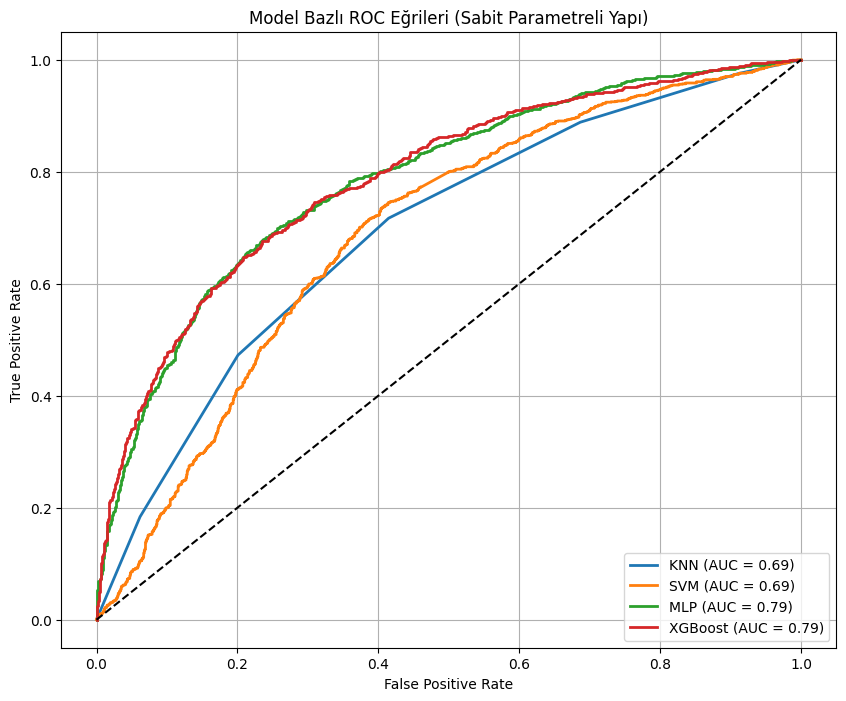


En çok seçilen 15 özellik (sabit yapı):
4: 20 fold
6: 20 fold
13: 20 fold
25: 20 fold
26: 20 fold
27: 20 fold
28: 20 fold
10: 19 fold
9: 19 fold
17: 16 fold
18: 15 fold
23: 14 fold
14: 6 fold
11: 5 fold
16: 5 fold


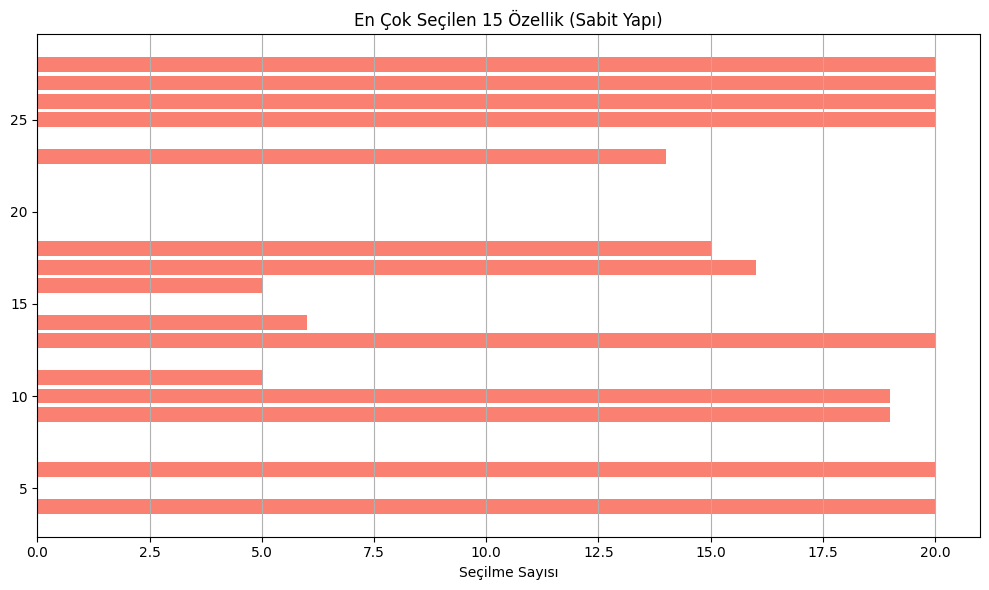


Sabit Yapı Sonuçları (Model Bazlı)
    fold    model  k_best  outer_acc  outer_auc
0      1      KNN       9   0.647476   0.685403
1      1      SVM      18   0.650237   0.680249
2      1      MLP      11   0.681782   0.745479
3      1  XGBoost      14   0.693218   0.770626
4      2      KNN      12   0.634858   0.678564
5      2      SVM      19   0.643533   0.675635
6      2      MLP      12   0.686909   0.758717
7      2  XGBoost      13   0.707808   0.777914
8      3      KNN       9   0.656151   0.706317
9      3      SVM      18   0.655757   0.696699
10     3      MLP      11   0.704653   0.771643
11     3  XGBoost      14   0.716088   0.790213
12     4      KNN      12   0.656546   0.693791
13     4      SVM      14   0.659306   0.690550
14     4      MLP      10   0.697161   0.757181
15     4  XGBoost      12   0.720820   0.787782
16     5      KNN       9   0.646548   0.685684
17     5      SVM      14   0.636686   0.668073
18     5      MLP       8   0.694280   0.753646
19  

In [ ]:
# 📈 ROC Eğrileri – Model Bazlı
plt.figure(figsize=(10, 8))
for model_name in results_df_fixed['model'].unique():
    model_rows = results_df_fixed[results_df_fixed['model'] == model_name]
    best_row = model_rows.sort_values(by='outer_acc', ascending=False).iloc[0]

    model = models_fixed[model_name]
    best_k = best_row['k_best']
    fold_index = best_row['fold'] - 1

    train_idx, val_idx = list(outer_cv.split(X_train, y_train))[fold_index]
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    pipeline = Pipeline([
        ('select', SelectKBest(score_func=f_classif, k=best_k)),
        ('clf', model)
    ])
    pipeline.fit(X_tr, y_tr)
    y_proba = pipeline.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f"{model_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model Bazlı ROC Eğrileri (Sabit Parametreli Yapı)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 📊 En çok seçilen özellikler
print("\nEn çok seçilen 15 özellik (sabit yapı):")
for feature, count in feature_counts_fixed.most_common(15):
    print(f"{feature}: {count} fold")

plt.figure(figsize=(10, 6))
features, counts = zip(*feature_counts_fixed.most_common(15))
plt.barh(features[::-1], counts[::-1], color='salmon')
plt.title("En Çok Seçilen 15 Özellik (Sabit Yapı)")
plt.xlabel("Seçilme Sayısı")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

# 📋 Sonuç tablosu
print("\nSabit Yapı Sonuçları (Model Bazlı)")
print(results_df_fixed[['fold', 'model', 'k_best', 'outer_acc', 'outer_auc']])
print("\nOrtalama Accuracy:", results_df_fixed['outer_acc'].mean())
print("Ortalama ROC-AUC:", results_df_fixed['outer_auc'].mean())




---
***** FLOWCHART - B - Başlangıç *****

---






---
Gerekli Kütüphaneler yükleniyor.


In [ ]:
!pip install xgboost optuna

import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from collections import Counter
from optuna.samplers import TPESampler


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 14.9 MB/s eta 0:00:00


---
Drive içerisine alınan HIGGS veri setinin 100 bin lik örneği okunuyor.


In [ ]:
# Veri Yükleme
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Makine Öğrenmesi/HIGGS_100bin.csv", header=None)
df_sample = df.sample(n=20000, random_state=42)

---
ilk kolon ayrı tutularak aykırı değer temizliği yapılıyor.


In [ ]:
y = df_sample.iloc[:, 0]
X = df_sample.drop(columns=df_sample.columns[0])

# Aykırı Değer Temizliği (IQR)
mask = pd.Series([True] * X.shape[0], index=X.index)

for col in X.columns:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    mask &= (X[col] >= lower) & (X[col] <= upper)

X_clean = X[mask]
y_clean = y[mask]

---
Standart Scaler ile sayısal veriler ölçekleniyor.

In [ ]:
# StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_clean.columns, index=X_clean.index)

---
Dışta 5 fold içeride 3 fold olacak şekilde cross validation yapısı kuruluyor.



*   FLOWCHART - B
*   Optuna ile en iyi hiperparametreler belirleniyor.

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Model bazlı optuna objective fonksiyonları
def create_objective(model_name, X, y, inner_cv):
    def objective(trial):
        # Ortak: Özellik sayısı
        k = trial.suggest_int("k", 5, min(20, X.shape[1]))

        # Model özel parametreler
        if model_name == "KNN":
            params = {
                "n_neighbors": trial.suggest_int("n_neighbors", 3, 11)
            }
            model = KNeighborsClassifier(**params)
        elif model_name == "SVM":
            params = {
                "C": trial.suggest_float("C", 0.01, 10.0, log=True),
                "kernel": trial.suggest_categorical("kernel", ["linear", "rbf"])
            }
            model = SVC(**params, probability=True)
        elif model_name == "MLP":
            params = {
                "hidden_layer_sizes": trial.suggest_categorical("hidden_layer_sizes", [(50,), (100,)]),
                "activation": trial.suggest_categorical("activation", ["relu", "tanh"])
            }
            model = MLPClassifier(**params, max_iter=500)
        else:  # XGBoost
            params = {
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
                "max_depth": trial.suggest_int("max_depth", 3, 10)
            }
            model = XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss')

        pipeline = Pipeline([
            ('select', SelectKBest(score_func=f_classif, k=k)),
            ('clf', model)
        ])

        scores = cross_val_score(pipeline, X, y, cv=inner_cv, scoring="accuracy")
        return scores.mean()

    return objective

# Optuna yapı
optuna_results = []
feature_counts_optuna = Counter()

for outer_fold, (train_idx, val_idx) in enumerate(outer_cv.split(X_train, y_train), 1):
    print(f"\n⏳ Outer Fold {outer_fold}")
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    for model_name in models_fixed.keys():
        study = optuna.create_study(direction="maximize", sampler=TPESampler(seed=42))
        objective = create_objective(model_name, X_tr, y_tr, inner_cv)
        study.optimize(objective, n_trials=30, timeout=60, show_progress_bar=False)

        trial = study.best_trial
        k_best = trial.params["k"]
        trial_params = trial.params.copy()
        del trial_params["k"]

        if model_name == "KNN":
            model = KNeighborsClassifier(**trial_params)
        elif model_name == "SVM":
            model = SVC(**trial_params, probability=True)
        elif model_name == "MLP":
            model = MLPClassifier(**trial_params, max_iter=500)
        else:
            model = XGBClassifier(**trial_params, use_label_encoder=False, eval_metric='logloss')

        pipeline = Pipeline([
            ('select', SelectKBest(score_func=f_classif, k=k_best)),
            ('clf', model)
        ])

        pipeline.fit(X_tr, y_tr)
        y_pred = pipeline.predict(X_val)
        y_proba = pipeline.predict_proba(X_val)[:, 1]

        acc = accuracy_score(y_val, y_pred)
        auc_score = roc_auc_score(y_val, y_proba)

        selector = pipeline.named_steps['select']
        selected_features = X_tr.columns[selector.get_support()]
        feature_counts_optuna.update(selected_features)

        # 🔁 Her modelin sonucu ayrı ayrı kaydedilir
        optuna_results.append({
            'fold': outer_fold,
            'model': model_name,
            'params': trial_params,
            'k_best': k_best,
            'outer_acc': acc,
            'outer_auc': auc_score,
            'selected_features': list(selected_features)
        })

# DataFrame'e dönüştür
results_df_optuna = pd.DataFrame(optuna_results)


⏳ Outer Fold 1


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contain


⏳ Outer Fold 2


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contain


⏳ Outer Fold 3


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contain


⏳ Outer Fold 4


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contain


⏳ Outer Fold 5


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  w

---
Oluşan sonuçlara göre;

*   ROC Eğrileri
*   Detaylı Sonuçlar
*   Özellik Seçim Sonuçları Analizi
*   Özellik Seçim Grafikleri
*   Sonuç Test Analizleri
yazdırılıyor


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:38:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


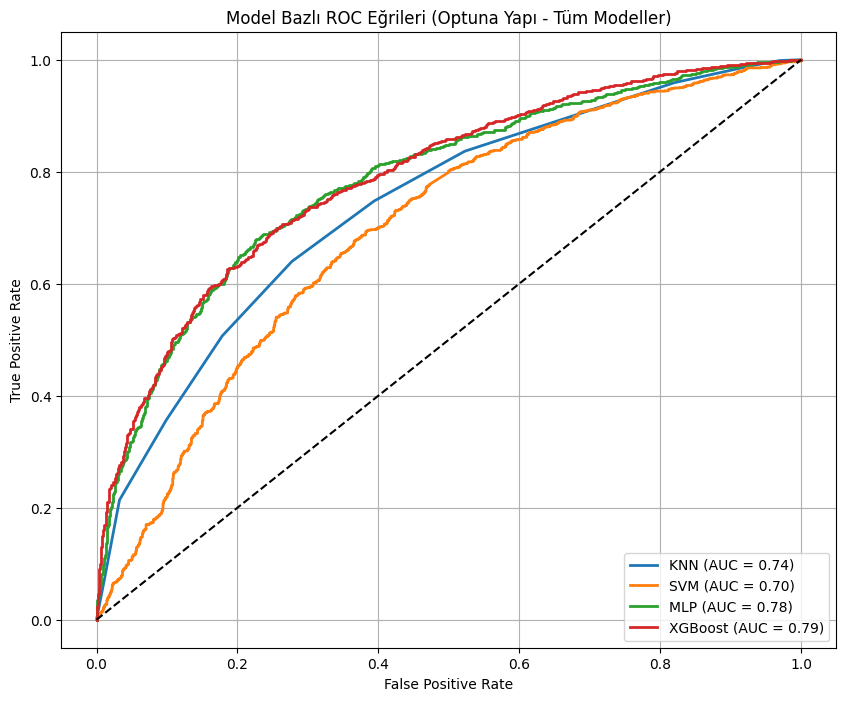


En çok seçilen 15 özellik (Optuna yapı):
4: 20 fold
6: 20 fold
10: 20 fold
13: 20 fold
26: 20 fold
27: 20 fold
28: 20 fold
9: 19 fold
25: 19 fold
17: 16 fold
23: 10 fold
18: 7 fold
11: 4 fold
14: 4 fold
16: 4 fold


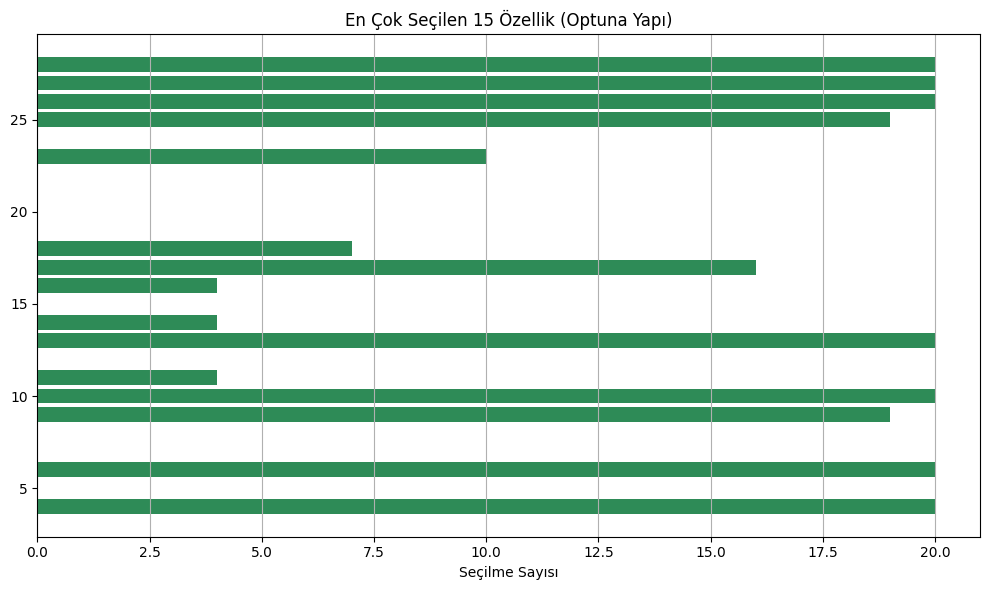


Optuna Yapı Sonuçları (Tüm Modeller, Tüm Foldlar):
    fold    model  k_best  outer_acc  outer_auc
0      1      KNN       8   0.651814   0.705938
1      1      SVM      10   0.646293   0.673873
2      1      MLP      10   0.686120   0.754373
3      1  XGBoost      18   0.694401   0.769335
4      2      KNN      12   0.646293   0.700232
5      2      SVM      10   0.649842   0.675015
6      2      MLP      10   0.685726   0.757038
7      2  XGBoost      16   0.706230   0.776092
8      3      KNN      10   0.682571   0.740048
9      3      SVM      10   0.660095   0.697171
10     3      MLP      10   0.721609   0.788621
11     3  XGBoost      18   0.714117   0.790095
12     4      KNN      12   0.673107   0.724537
13     4      SVM      10   0.647871   0.683172
14     4      MLP      10   0.687697   0.754146
15     4  XGBoost      15   0.713722   0.786650
16     5      KNN       9   0.664694   0.712624
17     5      SVM      10   0.643393   0.669675
18     5      MLP      10   0.688363

In [ ]:
# ROC Eğrisi: Artık her modelin en iyi fold'u çizilebilir
plt.figure(figsize=(10, 8))

for model_name in results_df_optuna['model'].unique():
    model_rows = results_df_optuna[results_df_optuna['model'] == model_name]
    best_row = model_rows.sort_values(by='outer_acc', ascending=False).iloc[0]

    k_best = best_row['k_best']
    params = best_row['params']
    fold_index = best_row['fold'] - 1

    if model_name == "KNN":
        model = KNeighborsClassifier(**params)
    elif model_name == "SVM":
        model = SVC(**params, probability=True)
    elif model_name == "MLP":
        model = MLPClassifier(**params, max_iter=500)
    else:
        model = XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss')

    train_idx, val_idx = list(outer_cv.split(X_train, y_train))[fold_index]
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    pipeline = Pipeline([
        ('select', SelectKBest(score_func=f_classif, k=k_best)),
        ('clf', model)
    ])
    pipeline.fit(X_tr, y_tr)
    y_proba = pipeline.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f"{model_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model Bazlı ROC Eğrileri (Optuna Yapı - Tüm Modeller)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print("\nEn çok seçilen 15 özellik (Optuna yapı):")
for feature, count in feature_counts_optuna.most_common(15):
    print(f"{feature}: {count} fold")

plt.figure(figsize=(10, 6))
features, counts = zip(*feature_counts_optuna.most_common(15))
plt.barh(features[::-1], counts[::-1], color='seagreen')
plt.title("En Çok Seçilen 15 Özellik (Optuna Yapı)")
plt.xlabel("Seçilme Sayısı")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

print("\nOptuna Yapı Sonuçları (Tüm Modeller, Tüm Foldlar):")
print(results_df_optuna[['fold', 'model', 'k_best', 'outer_acc', 'outer_auc']])
print("\nOrtalama Accuracy:", results_df_optuna['outer_acc'].mean())
print("Ortalama ROC-AUC:", results_df_optuna['outer_auc'].mean())


SONUÇ ve DEĞERLENDİRME
---

*   Sonuçlar veri setinin 20 bin lik kısmından elde edildi.
*   Elde edilen sonuçlar karşılaştırıldığında;
*   Optuna ile hiperparametre optimizasyonu yapılan yapı hem Accuracy hem de ROC-AUC ortalamasında daha iyi sonuç verdi.

*   XGBoost modeli her iki yapıda da en iyi sonuçlar ile öne çıktı.
*   Optuna yapısının KNN ve SVM modellerinde fayda sağladığı görüldü.
*   Veri setinin büyüklüğü dikkate alındığında Optuna lı yapının doğruluğunun daha yüksek olacağı öngörülebilir.







